In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [12]:
n = 2
grover_circuit = QuantumCircuit(n)

In [13]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [18]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

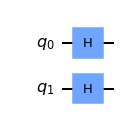

In [15]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw(output="mpl")

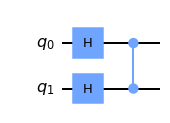

In [16]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw(output="mpl")

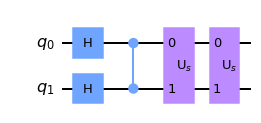

In [19]:
# Diffusion operator (U_s)
grover_circuit.append(diffuser(n),[0,1])
grover_circuit.draw(output="mpl")

In [8]:
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

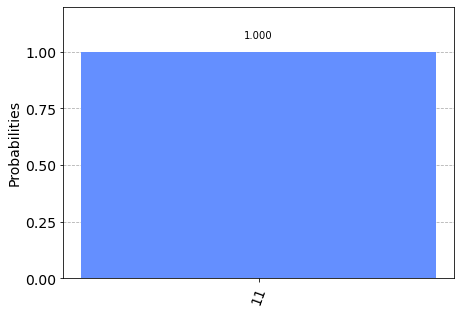

In [9]:
grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

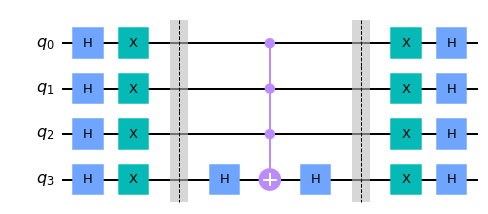

In [5]:
nqubits = 4

qc = QuantumCircuit(nqubits)
# Apply transformation |s> -> |00..0> (H-gates)
for qubit in range(nqubits):
    qc.h(qubit)
# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(nqubits):
    qc.x(qubit)
qc.barrier()
# Do multi-controlled-Z gate
qc.h(nqubits-1)
qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
qc.h(nqubits-1)
qc.barrier()
# Apply transformation |11..1> -> |00..0>
for qubit in range(nqubits):
    qc.x(qubit)
# Apply transformation |00..0> -> |s>
for qubit in range(nqubits):
    qc.h(qubit)
    
qc.draw(output="mpl")

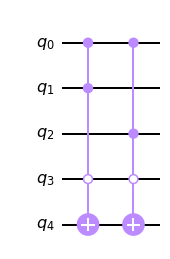

In [7]:
from qiskit.circuit import classical_function, Int1

# define a classical function f(x): this returns 1 for the solutions of the problem
# in this case, the solutions are 1010 and 1100
@classical_function
def f(x1: Int1, x2: Int1, x3: Int1, x4: Int1) -> Int1:
    return (x1 and not x2 and x3 and not x4) or (x1 and x2 and not x3 and not x4)

nqubits = 4
    
Uf = f.synth()  # turn it into a circuit
oracle = QuantumCircuit(nqubits+1)
oracle.compose(Uf, inplace=True)

oracle.draw(output="mpl")
# We will return the diffuser as a gate
#U_f = oracle.to_gate()
# U_f.name = "U$_f$"
# return U_f